<a href="https://colab.research.google.com/github/Chuck2Win/Transformer_Scratch/blob/master/%5BTRANSFORMER_FROM_SCRATCH%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRANSFORMER
## Attention is all you need
논문의 핵심을 직접 구현해보기  
by pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
import copy

https://arxiv.org/pdf/1706.03762.pdf
Attention is all you need

In [ ]:
# Transformer model architecture

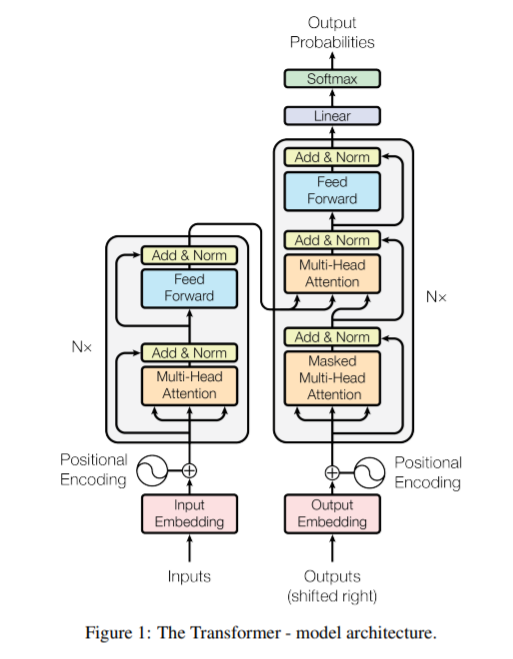


In [ ]:
# scaled dot product attention , multihead attention

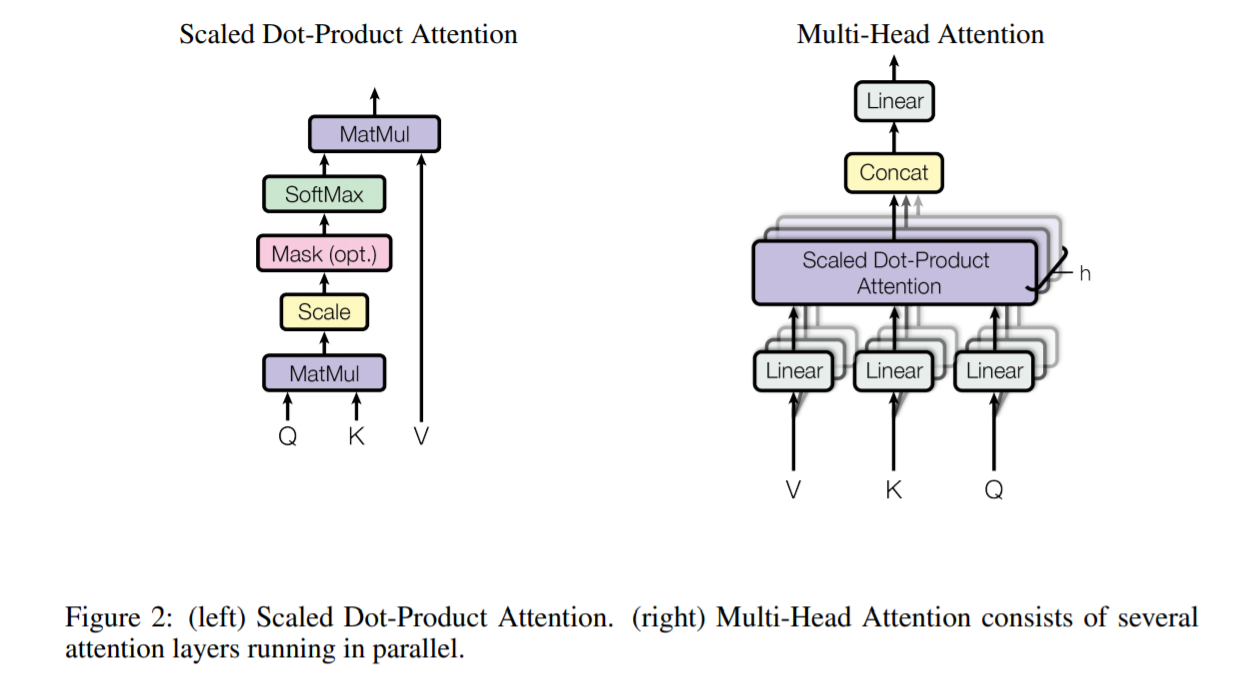

In [ ]:
# SCALED DOT PRODUCT ATTENTION

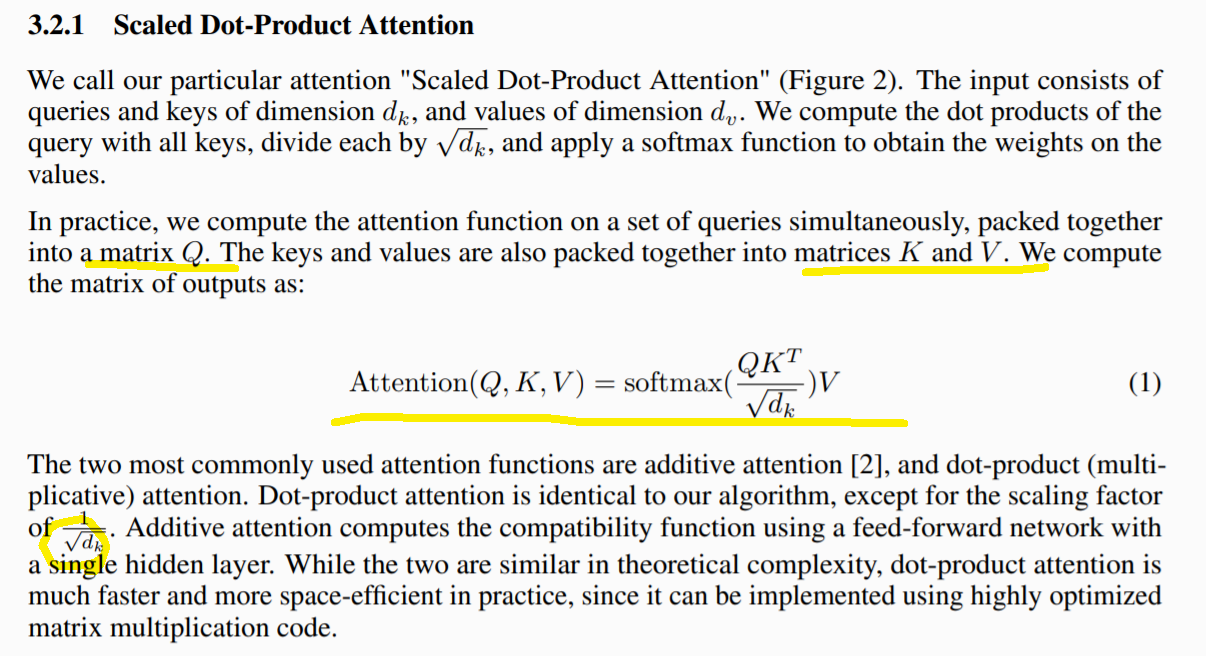

In [ ]:
# config
class Config(dict):
    __getattr__=dict.__getitem__
    __setitem__=dict.__setitem__

In [ ]:
config=Config({'n_layers':1,'n_heads':8,'d_model':512,'d_k':512//8,'dropout':0.1})

In [ ]:
config

{'d_k': 64, 'd_model': 512, 'n_heads': 8, 'n_layers': 1}

In [ ]:
def subsquent_mask(src):
    '''
    src shape : seq_len_1, batch size
    out put shape : seq_len_1, seq_len_1 (mask씌울 부분을 -1e9, 아닌 부분을 0)
    '''
    s=src.size(0)
    mask=torch.triu(torch.ones((s,s)),1)==1
    mask=mask.float().masked_fill(mask,-1e9) # True 인 부분을 -1e9로 채운다.
    return mask
def  padding_mask(tgt,padding_idx):
    '''
    tgt에서 padding idx와 같은 부분을 masking 씌운다.
    tgt shape : seq_len_2, batch size
    out put shape : batch size, seq_len_2 (mask씌울 부분을 True, 아닌 부분을 FALSE)
    '''
    out=tgt.eq(padding_idx)
    return out.T 

In [ ]:
class ScaledDotAttention(nn.Module):
    def __init__(self):
        super(Attention,self).__init__()
    def forward(self,Q,K,V,subsquent_mask=None,padding_mask=None):
        '''
        Q shape : seq_len_1,batch_size,d_k
        K shape : seq_len_2,batch_size,d_k
        V shape : seq_len_2,batch_size,d_v
        mask shape : seq_len_1, seq_len_2
        mask의 종류는 2가지, subsquent mask, padding mask
        nn.Transformer에서는 subsquent mask는 seq_len_1,seq_len_2 형태로
        padding mask는 batch_size,seq_len 형태로 처리한다.
        그리고 subsquent mask는 mask가 되어야 될 부분을 -inf, 나머지는 0 
        -> Additive 방식으로서, 아래 내 함수에서 softmax을 씌우기 전 out으로 된 부분에 더해주는 식으로 해서
        -> softmax를 취하면 결과론적으로 subsqeunt mask에서 mask가 되어야될 부분을 0으로 아닌 부분을 해당 값을 산출하게 끔 한다.
        padding mask는 mask가 되어야 될 부분을 True(1), 아닌 부분을 False(0)로 한다(masked_fill function 탓) 
        -> padding mask는 더하는 방식이 아니라 Softmax 결과에 masked_fill 함수를 사용해서 덮는 방식이다. 
        '''
        Q=Q.transpose(0,1) # batch size, seq_len_1, d_k
        K=K.transpose(0,1) # batch size, seq_len_2, d_k
        out=Q.matmul(K.transpose(1,2))/math.sqrt(self.config.d_k) # batch size, seq_len_1, seq_len_2
        if subsquent_mask is not None:
            out= out + subsquent_mask.unsqueeze(0)
        out=F.softmax(out,dim=-1) # batch size, seq_len_1, seq_len_2
        if padding_mask is not None:
            out = out.masked_fill(padding_mask.unsqueeze(1),0)
        output=out.matmul(V.transpose(0,1)) # batch size, seq_len_1,d_k
        return output

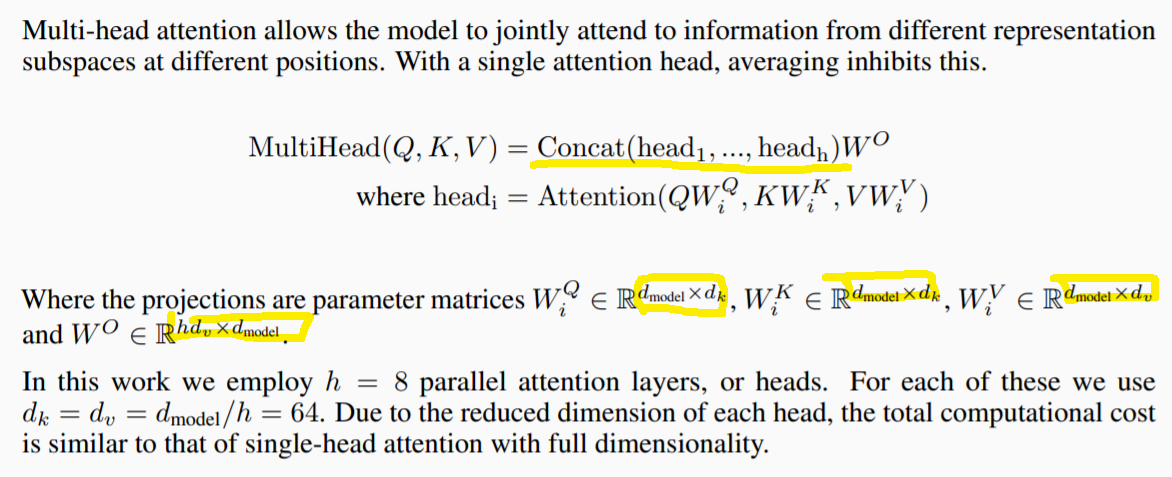

In [ ]:
def clones(module, N):
    "N개의 모듈 복사"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)]) #  deep copy는 독립적인 복사를 꾀한다.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention,self).__init__()
        self.config=config
        self.attention=ScaledDotAttention()
        self.linear=clones(nn.Linear(self.config.d_model,self.config.d_model),3) # Q,K,V
        self.linear_cat=nn.Linear(self.config_d_model,self.config_d_model)
        
    def forward(self, Q,K,V,subsquent_mask=None,padding_mask=None):
        '''
        Q shape : seq_len_1, batch size, d_model
        K shape : seq_len_2, batch size, d_model
        V shape : seq_len_2, batch size, d_model
        ------------------1---------------------
        Q shape : h,seq_len_1, batch size, d_k (q)
        K shape : h,seq_len_2, batch size, d_k (k)
        V shape : h,seq_len_2, batch size, d_v (v)
        '''
        Q=Q.transpose(0,-1).reshape(self.config.n_heads,self.config.d_k,-1,Q.size(0)).tranpose(1,-1)
        K=K.transpose(0,-1).reshape(self.config.n_heads,self.config.d_k,-1,K.size(0)).tranpose(1,-1)
        V=V.transpose(0,-1).reshape(self.config.n_heads,self.config.d_k,-1,V.size(0)).tranpose(1,-1)
        [q,k,v]=[l(x) for l,x in zip(self.linear,[Q,K,V])]
        attention_output=[]
        for i in range(self.config.n_heads):
            attention_output.append(self.attention(q[i,:,:,:],k[i,:,:,:],v[i,:,:,:],subsquent_mask,padding_mask))
        # attention output shape : h, seq_len_1,batch_size,d_k
        attention_output=torch.tensor(attention_output,device=Q.device).transpose(0,1).transpose(1,2)  # seq_len_1,batch_size,h,d_k
        output = self.linear_cat(attention_output) # seq_len_1,batch_size,h,d_k
        
        return output

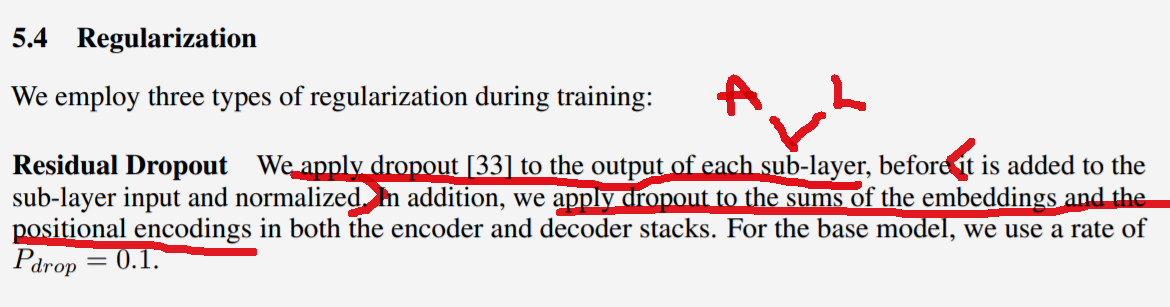

In [ ]:
a=torch.randn((10,32,100))
a.std(-1,keep_dim=True).shape

torch.Size([10, 32])

In [ ]:
a.size()

torch.Size([10, 32, 100])

In [ ]:
# LayerNorm
# Layer Norm
# a*(x-m)/(sigma+eps)+b (elemente wise product and add)
# a,b is paramerter
class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-7):
        super(LayerNorm,self).__init__()
        self.a=torch.ones_like(features,requires_grad=True)  # features : seq len , d_model
        self.b=torch.zeros_like(features,requires_grad=True) # batch size는 변경될 수 있기 때문에 안넣어줌.
        self.eps=eps
    def forward(self,input):
        '''
        input shape : seq_len, batch_size, d_model
        output shaep : seq_len, batch size, d_model
        '''
        m=input.mean(-1,keep_dim=True) # seq len, batch size, d_model
        sigma=input.std(-1,keep_dim=True) # seq len, batch size, d_model
        return self.a.unsqueeze(1)*(input-m)/(sigma+self.eps)+self.b.unsqueeze(1)

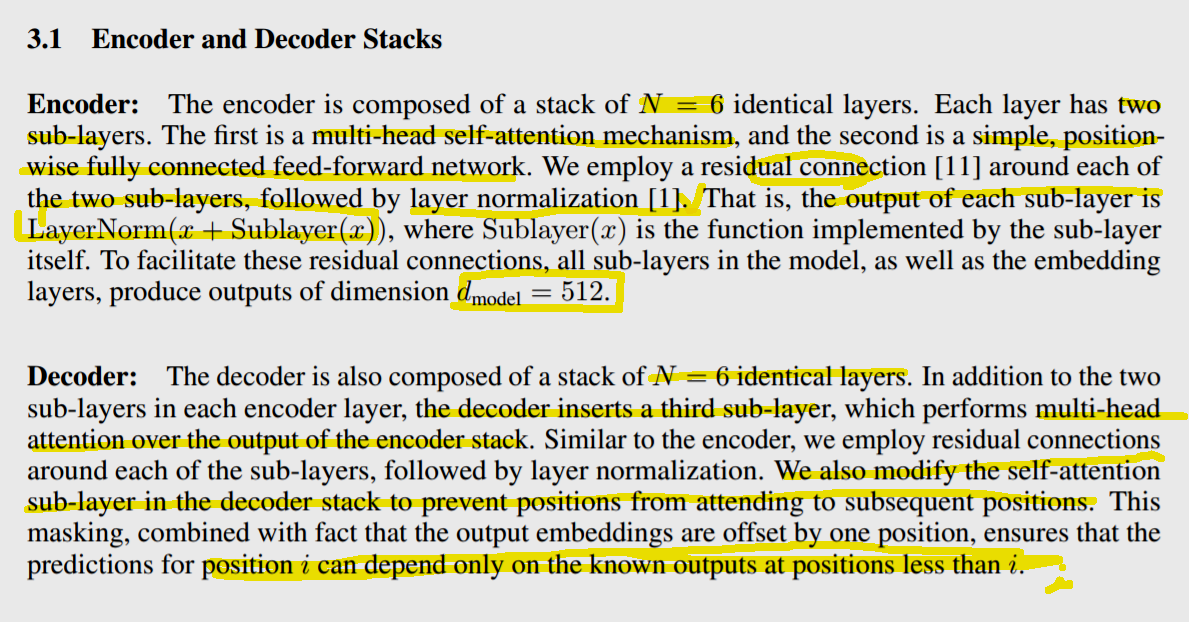

In [ ]:
class SublayerConnection(nn.Module):
    def __init__(self,config,features):
        super(SublayerConnection,self).__init__()
        self.config=config
        self.dropout=nn.Dropout(self.config.dropout)
        self.layernorm=LayerNorm(features)
    def forward(self,x,sublayer):
        '''
        논문에서 sublayer의 output에는 항상 dropout을 취해주고(0.1)
        residual net을 적용한다고 했음, 그 후에 LayerNorm을 취한다.
        LayerNorm(x+dropout(sublayer))
        '''
        return self.layernorm(x+self.dropout(sublayer)

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention,self).__init__()
        self.config=config
        self.linear=nn.Sequential(nn.Linear(self.config.d_model,self.config.d_ff),nn.ReLU(),nn.Dropout(self.config.dropout), \
                                  nn.Linear(self.config.d_ff,self.config.d_model))
    def forward(self,input):
        output=self.linear(input)
        return output

In [ ]:
# DecoderLayer 만들기
# Decoder는 6개의 DecoderLayer로 구성
# 각 layer는 3개의 sub layer로 구성
# sublayer 1 : tgt self masked multihead attention
# sublayer connection : LN(x+dropout(sublayer(x))) <- dropout , residual connection , layer norm으로 구성됨
# sublayer 2 : enc-dec multi head attention
# sublayer connection : LN(x+dropout(sublayer(x))) <- dropout , residual connection , layer norm으로 구성됨
# sublayer 3 : FeedForwardNetwork

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self,config):
        self.config=config
        features=(self.config.seq_len_2,self.config.d_model)
        self.sublayers=nn.ModuleList(MultiHeadAttention(config),MultiHeadAttention(config),FeedForwardNetwork(config))
        self.sublayer_connections=clones(SublayerConnection(self.config,features),3)
    def forward(self,decoder_input,memory,decoder_subsquent_mask=None,decoder_padding_mask=None, memory_padding_mask=None):
        '''
        decoder input shape : seq_len_2, batch size, d_model
        decoder input은 positional encoding과 token embedding의 결과물이다 (물론 여기에 drop out을 취해 준 결과)
        memory shape : seq_len_1, batch size, d_model
        memory는 encoder의 최종적인 output이다(multi head attention과 FFN을 통과한 결과물)
        memory padding mask는 encoder의 초기 input(encoder도 6개의 layer로 이뤄져있는 데, FFN을 거치게 되면 mask를 씌워주더라도 그 부분의 값이
        0 이 아니게 된다. 그래서 decoder에 값을 넘겨줄 때 encoder의 padding idx도 같이 넘겨 줘야 된다.
        여기서 의문인 것은, decoder의 최종적인 결과물도 decoder padding mask를 다시 씌워줘야 된다고 생각하는 데
        nn.Criterion 계산 시 padding idx 는 ignore하게 해줘서 그 부분을 따로 안하는 것 같다.
        nn.CrossEntropyLoss(ignore_index=1))
        '''
        output1=self.dec_masked_multi_head_attention(decoder_input,decoder_input,decoder_input,subsquent_mask=decoder_subsquent_mask,padding_mask=decoder_padding_mask)
        output1=self.sublayer_connection_1(decoder_input,output1)
        output2=self.dec_enc_multi_head_attention(output1,memory,memory,padding_mask=memory_padding_mask)
        output2=self.sublayer_connection_2(output1,output2)
        output3=self.feedforwardnetwork(output2)
        output3=self.sublayer_connection_2(output1,output2)
        